In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
from modules_gd.model import VAE
# help(VAE)
from modules_gd.data import MSA_Dataset
# help(MSA_Dataset)

## Inspect the pre-processed MSA

In [3]:
MSA_id = "PF00144"
query_seq_id = "0A010Q9K6_9PEZI/15-292"
data_path = f"data/Ding/processed/{MSA_id}"

In [4]:
!echo Total number of sequences:
! wc -l {data_path}/seq_msa_char.txt 
!echo Check that query sequence present:
! grep {query_seq_id} {data_path}/seq_msa_char.txt 
#!echo Check that outgroup sequence present:
#! grep {outgroup_acc} {data_path}/seq_msa_char.txt
!echo Print first 25 sequences:
! head -n 25 {data_path}/seq_msa_char.txt 

Total number of sequences:
   23894 data/Ding/processed/PF00144/seq_msa_char.txt
Check that query sequence present:
A0A010Q9K6_9PEZI/15-292	DTEILYNRCRGNKKAETKEQITLDDAFRGFSCTKLITTISVLQCVEKKMIGLDDEIESILPFRLERAKNKITVRHLLTHTSGISYDMHPLLVAWRQSRSGRTIEAFSLPLLFEPGTSWVYGAGLDWAGVLVERLSNVKLATYMEEHLFRPLGLTNTTLHIKERPDMRRAQMFLRTEEGKLAPIPSPYPEDGGMGLITTTSDFVKILLLKDSPVLLKAESVTAMFTPQFD
Print first 25 sequences:
A0A010Q9K6_9PEZI/15-292	DTEILYNRCRGNKKAETKEQITLDDAFRGFSCTKLITTISVLQCVEKKMIGLDDEIESILPFRLERAKNKITVRHLLTHTSGISYDMHPLLVAWRQSRSGRTIEAFSLPLLFEPGTSWVYGAGLDWAGVLVERLSNVKLATYMEEHLFRPLGLTNTTLHIKERPDMRRAQMFLRTEEGKLAPIPSPYPEDGGMGLITTTSDFVKILLLKDSPVLLKAESVTAMFTPQFD
A0A010QDI9_9PEZI/44-382	DNNTW.AKGYGYAVLNST.PVTPHTLYFTGSTTKSFTAAGISLLIDNAGLSWKTPVSHILRS.DEWATAHITLEDAMSHRTGYPRHDLAPATTAQ....GTTRLLRHLPMAAEPRTTFLYNNKMFAMGYLIEVLTGSWLGDFFREYLWEPMAMNETYFSLKDAEQSGLVLAKYYYNPDDGSYLEVPHEPSGAGSIVSNVLDYAKYLMTESAPISKMGHREVKVIATHIL
A0A010QH97_9PEZI/4-377	.SGSFQYSHIYGDNLKSARPLSDDNILTLASVTKLFTTIAALQLVERGILTLDGDVSKHIPPIEVQRKKPITL

## Load data and instantiate dataset

In [5]:
## read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([23894, 229, 21])

In [6]:
## each sequence has a label
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
seq_names[:10]

['A0A010Q9K6_9PEZI/15-292',
 'A0A010QDI9_9PEZI/44-382',
 'A0A010QH97_9PEZI/4-377',
 'A0A010QLE8_9PEZI/83-430',
 'A0A010R563_9PEZI/46-413',
 'A0A010RB36_9PEZI/59-388',
 'A0A010RBL1_9PEZI/14-378',
 'A0A010RQ09_9PEZI/15-378',
 'A0A010RQ92_9PEZI/313-607',
 'A0A010S3V9_9PEZI/5-388']

In [7]:
## sequences in msa are weighted
with open(f"{data_path}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
print(np.sum(seq_weight))

1.0


In [9]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random sample
data[100]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]),
 2.6213427e-05,
 'A0A023NX70_9GAMM/23-346')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [10]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [11]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[-0.0643, -0.0184]], grad_fn=<AddmmBackward0>), tensor([[1.0485, 0.9281]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 229, 21]) and is given by:
tensor([[[-2.8937, -3.0467, -2.9559,  ..., -3.1235, -3.1208, -3.0755],
         [-3.0292, -3.2196, -2.9279,  ..., -2.9750, -3.0010, -3.0852],
         [-2.9847, -3.0419, -3.0145,  ..., -3.0388, -3.0248, -3.0676],
         ...,
         [-2.9237, -3.0917, -2.8779,  ..., -3.0333, -3.0436, -3.0896],
         [-3.0675, -3.0362, -2.9857,  ..., -3.0424, -2.9597, -2.9911],
         [-3.0692, -3.0190, -3.0693,  ..., -3.0233, -3.1153, -3.1834]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0554, 0.0475, 0.0520,  ..., 0.0440, 0.0441, 0.0462],
        [0.0484, 0.0400, 0.0535,  ..., 0.0510, 0.0497, 0.0457],
        [0.0506, 0.0477, 0.0491,  ..., 0.0479, 0.0486, 0.0465],
        ...,
        [0.0537, 0.0454, 0.0563,  ..., 0.0482,

## Train model

In [12]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size = 0.1)
train_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(train_idx))
test_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(test_idx))

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 30
weight_decay = 0.01
dim_lat = 2
batch_size = 32
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100)
      elbo_scalar = torch.sum(elbo).data.item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, sigma = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



cpu


In [15]:
train_losses = []
test_elbos = []
test_recon_accs = []

# Instantiate a new model for this fold
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, test_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
  epoch_train_loss = np.mean(batch_losses)
  train_losses.append(epoch_train_loss)
  print(f"Training loss for epoch {epoch}: {epoch_train_loss}")
  

Test elbo for epoch 0: -22272.436028478256
Test reconstruction accuracy for fold epoch 0: 0.04489165683587392
Training loss for epoch 0: 488.8780206952776
Test elbo for epoch 1: -14327.071355080518
Test reconstruction accuracy for fold epoch 1: 0.397637456258138
Training loss for epoch 1: 453.9954298564366
Test elbo for epoch 2: -13815.80083132777
Test reconstruction accuracy for fold epoch 2: 0.42103447278340655
Training loss for epoch 2: 442.56456770215715
Test elbo for epoch 3: -13533.511559938366
Test reconstruction accuracy for fold epoch 3: 0.4328361105918884
Training loss for epoch 3: 435.1802361352103
Test elbo for epoch 4: -13351.156663134818
Test reconstruction accuracy for fold epoch 4: 0.4412916843096415
Training loss for epoch 4: 429.6361547651745
Test elbo for epoch 5: -13202.166490615216
Test reconstruction accuracy for fold epoch 5: 0.44844316522280375
Training loss for epoch 5: 425.2877262206305
Test elbo for epoch 6: -13090.546118445522
Test reconstruction accuracy fo

In [17]:
# Save model
from datetime import date
import os
os.makedirs(f"saved_models/{MSA_id}", exist_ok = True)
model.cpu()
today = date.today()
torch.save(model.state_dict(), f"saved_models/{MSA_id}/model_{today}.pt")

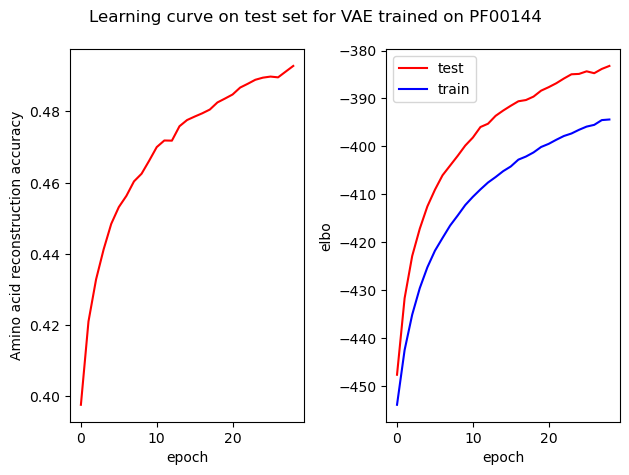

In [18]:
# plot learning curve
fig, axs = plt.subplots(1, 2)

axs[0].plot(test_recon_accs[1:], color = 'r')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel(f"Amino acid reconstruction accuracy")

axs[1].plot([x/batch_size for x in test_elbos[1:]], label = "test", color = 'r')
axs[1].plot([-x for x in train_losses[1:]], label = "train", color = 'b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel(f"elbo")
axs[1].legend()

# add title
plt.suptitle(f"Learning curve on test set for VAE trained on {MSA_id}")
plt.tight_layout()
